# Skin Disease Detection

In [ ]:
pip install gcsfs

## Load datasets

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### SCIN Dataset

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import gcsfs
# Load SCIN dataset
scin_cases = pd.read_csv("/content/drive/MyDrive/extracted_data/scin_cases.csv")
scin_labels = pd.read_csv("/content/drive/MyDrive/extracted_data/scin_labels.csv")
scin_data = scin_cases.merge(scin_labels, on='case_id')

In [ ]:
scin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 73 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   int64  
 1   source                                              5033 non-null   object 
 2   release                                             5033 non-null   object 
 3   year                                                5033 non-null   int64  
 4   age_group                                           5032 non-null   object 
 5   sex_at_birth                                        5032 non-null   object 
 6   fitzpatrick_skin_type                               2503 non-null   object 
 7   race_ethnicity_american_indian_or_alaska_native     73 non-null     object 
 8   race_ethnicity_asian                                96 non-null     object 
 9

In [ ]:
scin_data.head()

case_id source release  year     age_group  \
0 -1000600354148496558   SCIN   1.0.0  2023   AGE_UNKNOWN   
1 -1002039107727665188   SCIN   1.0.0  2023   AGE_UNKNOWN   
2 -1003358831658393077   SCIN   1.0.0  2023  AGE_18_TO_29   
3 -1003826561155964328   SCIN   1.0.0  2023   AGE_UNKNOWN   
4 -1003844406100696311   SCIN   1.0.0  2023  AGE_40_TO_49   

           sex_at_birth fitzpatrick_skin_type  \
0  OTHER_OR_UNSPECIFIED                   NaN   
1  OTHER_OR_UNSPECIFIED                   NaN   
2                  MALE       NONE_IDENTIFIED   
3  OTHER_OR_UNSPECIFIED                   NaN   
4                FEMALE                  FST3   

  race_ethnicity_american_indian_or_alaska_native race_ethnicity_asian  \
0                                             NaN                  NaN   
1                                             NaN                  NaN   
2                                             NaN                  NaN   
3                                             NaN                  NaN   
4                                             NaN                  NaN   

  race_ethnicity_black_or_african_american  ...  \
0                                      NaN  ...   
1                                      NaN  ...   
2                                      NaN  ...   
3                                      NaN  ...   
4                                      NaN  ...   

  dermatologist_gradable_for_fitzpatrick_skin_type_1  \
0                                                YES   
1                                                YES   
2                                                YES   
3                                                 NO   
4                                                YES   

  dermatologist_gradable_for_fitzpatrick_skin_type_2  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  dermatologist_gradable_for_fitzpatrick_skin_type_3  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

  dermatologist_fitzpatrick_skin_type_label_1  \
0                                        FST2   
1                                        FST1   
2                                        FST4   
3                                         NaN   
4                                        FST1   

  dermatologist_fitzpatrick_skin_type_label_2  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  dermatologist_fitzpatrick_skin_type_label_3  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  gradable_for_monk_skin_tone_india gradable_for_monk_skin_tone_us  \
0                              True                           True   
1                              True                           True   
2                              True                           True   
3                              True                           True   
4                              True                           True   

  monk_skin_tone_label_india monk_skin_tone_label_us  
0                        2.0                     1.0  
1                        3.0                     3.0  
2                        3.0                     4.0  
3                        2.0                     4.0  
4        

#### DermNet dataset

In [ ]:
# prompt: connect to google drive, extract the zip files "CV_DermNet.zip" and "Ham10000.zip"
import zipfile
import os

# Define the paths to your zip files in Google Drive
zip_file_paths = ["/content/drive/My Drive/CV_DermNet.zip", "/content/drive/My Drive/Ham10000.zip"]

# Define the extraction directory
extract_dir = "/content/drive/My Drive/extracted_data"  # Create this directory if it doesn't exist

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)


# Loop through the zip files and extract them
for zip_file_path in zip_file_paths:
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted {zip_file_path} to {extract_dir}")
    except FileNotFoundError:
        print(f"Error: {zip_file_path} not found in Google Drive.")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred while extracting {zip_file_path}: {e}")


Successfully extracted /content/drive/My Drive/CV_DermNet.zip to /content/drive/My Drive/extracted_data
Successfully extracted /content/drive/My Drive/Ham10000.zip to /content/drive/My Drive/extracted_data


In [ ]:
# Load DermNet dataset from directories
train_dir = "/content/drive/My Drive/extracted_data/CV_DermNet/train"
test_dir = "/content/drive/My Drive/extracted_data/CV_DermNet/test"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images
    batch_size=32,
    label_mode='int'  # Use 'int' for integer labels or 'categorical' for one-hot encoding
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 14893 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [ ]:
# Check class names
print(train_dataset.class_names)
classes = train_dataset.class_names

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


#### HAM10000 dataset

In [ ]:
# Load HAM10000 dataset
ham10000 = pd.read_csv("/content/drive/My Drive/extracted_data/Ham10000/HAM10000_metadata.csv")
ham10000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
ham10000

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

### Extract conditions and Inspect

In [ ]:
# Extract relevant columns
scin_conditions = scin_data["dermatologist_skin_condition_on_label_name"].dropna()
ham_conditions = ham10000["dx"].dropna()
dermnet_conditions = train_dataset.class_names

In [ ]:
# Find common conditions
common_conditions = set(scin_conditions) & set(ham_conditions) & set(dermnet_conditions)
print(f"Common conditions: {common_conditions}")

Common conditions: set()


In [ ]:
# Select top conditions (based on frequency in SCIN dataset)
scin_counts = Counter(scin_data["dermatologist_skin_condition_on_label_name"].dropna())
top_conditions = [condition for condition, _ in scin_counts.most_common(10)]
print(f"Top conditions: {top_conditions}")

Top conditions: ['[]', "['Eczema']", "['Urticaria']", "['Eczema', 'Allergic Contact Dermatitis']", "['Allergic Contact Dermatitis', 'Irritant Contact Dermatitis']", "['Allergic Contact Dermatitis']", "['Folliculitis']", "['Urticaria', 'Insect Bite', 'Allergic Contact Dermatitis']", "['Insect Bite']", "['Acute dermatitis, NOS']"]


#### SCIN - extract one dominant condition label for each case

In [ ]:
import pandas as pd
import ast

# Function to determine the dominant skin condition
def get_dominant_condition(row):
    try:
        # Convert string representations of lists into actual lists
        conditions = ast.literal_eval(row["dermatologist_skin_condition_on_label_name"]) if isinstance(row["dermatologist_skin_condition_on_label_name"], str) else row["dermatologist_skin_condition_on_label_name"]
        confidences = ast.literal_eval(row["dermatologist_skin_condition_confidence"]) if isinstance(row["dermatologist_skin_condition_confidence"], str) else row["dermatologist_skin_condition_confidence"]

        # Ensure data is valid before processing
        if isinstance(conditions, list) and isinstance(confidences, list) and len(conditions) == len(confidences) and len(conditions) > 0:
            # Pair conditions with their confidence values and get the one with the highest confidence
            dominant_condition = max(zip(conditions, confidences), key=lambda x: x[1])[0]
            return dominant_condition
    except (ValueError, SyntaxError, TypeError) as e:
        print(f"Error processing row {row.name}: {e}")  # Debugging output
        return None  # Handle errors gracefully

# Apply function to dataset
scin_data["dominant_skin_condition"] = scin_data.apply(get_dominant_condition, axis=1)

# # Save the processed dataset
# scin_data.to_csv("scin_dominant_conditions.csv", index=False)

# Check unique values to ensure it's working correctly
scin_data["dominant_skin_condition"].unique()

array(['Inflicted skin lesions', 'Prurigo nodularis', 'Impetigo', None,
       'Lichen planus/lichenoid eruption', 'Drug Rash', 'Urticaria',
       'Basal Cell Carcinoma', 'Eczema', 'Purpura', 'Skin infection',
       'Tinea Versicolor', 'Stasis Dermatitis', 'Hyperpigmentation',
       'Psoriasis', 'Infected eczema', 'Pityriasis rosea', 'Tinea',
       'Onychodystrophy', 'Folliculitis', 'Chronic dermatitis, NOS',
       'Acute and chronic dermatitis', 'Sweet syndrome', 'Insect Bite',
       'Allergic Contact Dermatitis', 'Herpes Simplex',
       'Fox-Fordyce disease', 'Pigmented purpuric eruption', 'Cyst',
       'Granuloma annulare', 'Herpes Zoster', 'Verruca vulgaris',
       'Confluent and reticulate papillomatosis', 'Photodermatitis',
       'Molluscum Contagiosum', 'Contact purpura', 'Xerosis', 'Acne',
       'Abscess', 'Rosacea', 'Miliaria', 'Abrasion, scrape, or scab',
       'wound/abrasion', 'Irritant Contact Dermatitis',
       'O/E - ecchymoses present', 'Erosion of skin', '

In [ ]:
missing_count = scin_data["dominant_skin_condition"].isna().sum()
total_rows = len(scin_data)

print(f"Missing dominant conditions: {missing_count} out of {total_rows}")


Missing dominant conditions: 1972 out of 5033


In [ ]:
import pandas as pd

# Display all columns and rows
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to prevent wrapping
pd.set_option('display.max_colwidth', None)  # Show full cell content


In [ ]:
# Count images per row
scin_data["image_count"] = scin_data[["image_1_path", "image_2_path", "image_3_path"]].notna().sum(axis=1)

# Group by dominant condition and sum the images
condition_image_counts = scin_data.groupby("dominant_skin_condition")["image_count"].sum().reset_index()

# Sort by highest count
condition_image_counts = condition_image_counts.sort_values(by="image_count", ascending=False)

# Display the top results
condition_image_counts

dominant_skin_condition  image_count
56                                                                       Eczema         1042
19                                                  Allergic Contact Dermatitis          546
196                                                                   Urticaria          442
96                                                                  Insect Bite          392
68                                                                 Folliculitis          301
190                                                                       Tinea          216
167                                                                   Psoriasis          215
90                                                                     Impetigo          139
84                                                                Herpes Zoster          135
154                                                 Pigmented purpuric eruption          131
31                                                      CD - Contact dermatitis          131
53                                                                    Drug Rash          129
5                                                                          Acne          128
14                                                        Acute dermatitis, NOS          112
83                                                               Herpes Simplex          106
99                                                  Irritant Contact Dermatitis           97
158                                                            Pityriasis rosea           92
191                                                            Tinea Versicolor           76
105                                                           Keratosis pilaris           74
111                                                    Lichen Simplex Chronicus           67
113                                            Lichen planus/lichenoid eruption           64
184                                                           Stasis Dermatitis           60
138                                                    O/E - ecchymoses present           55
173                                                                     Rosacea           54
109                                                 Leukocytoclastic Vasculitis           54
201                                                              Viral Exanthem           53
166                                                           Prurigo nodularis           51
11                                                 Acute and chronic dermatitis           51
75                                                           Granuloma annulare           50
200                                                            Verruca vulgaris           49
87                                                             Hypersensitivity           48
152                                                             Photodermatitis           44
2                                                     Abrasion, scrape, or scab           42
97                                                                   Intertrigo           40
176                                                                     Scabies           38
177                                                              Scar Condition           36
149                                                         Perioral Dermatitis           35
3                                                                       Abscess           34
33                                                                   Cellulitis           34
132                                                       Molluscum Contagiosum           33
168                                                                     Purpura           32
37                                                      Chronic dermatitis, NOS           29
178                                                      

#### Standardize the condition labels & Map them to a category


Used chatgpt to retreive the relevant category for each skin condition  

In [ ]:
classes = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'vasc': 'Vascular Tumors',
    'akiec': 'Actinic Keratoses and Intraepithelial Carcinoma',
    'df': 'Dermatofibroma'
}
# Normalize HAM10000 dataset conditions
ham10000['standardized_condition'] = ham10000["dx"].map(classes)
ham10000['standardized_condition'].value_counts()

standardized_condition
Melanocytic Nevi                                   6705
Melanoma                                           1113
Benign Keratosis-like Lesions                      1099
Basal Cell Carcinoma                                514
Actinic Keratoses and Intraepithelial Carcinoma     327
Vascular Tumors                                     142
Dermatofibroma                                      115
Name: count, dtype: int64

In [ ]:
skin_disease_mapping = {

   # HAM10000 dataset
    "Melanocytic Nevi": "Benign Skin Lesions",
    "Melanoma": "Malignant Skin Lesions",
    "Benign Keratosis-like Lesions": "Benign Skin Lesions",
    "Basal Cell Carcinoma": "Malignant Skin Lesions",
    "Actinic Keratoses and Intraepithelial Carcinoma": "Malignant Skin Lesions",
    "Vascular Tumors": "Vascular and Blood-Related Disorders",
    "Dermatofibroma": "Benign Skin Lesions",

       # SCIN dataset
    "Eczema": "Eczema and Dermatitis",
    "Allergic Contact Dermatitis": "Eczema and Dermatitis",
    "Urticaria": "Autoimmune and Inflammatory Disorders",
    "Insect Bite": "Other Skin Conditions",
    "Folliculitis": "Bacterial and Viral Infections",
    "Tinea": "Fungal and Parasitic Infections",
    "Psoriasis": "Autoimmune and Inflammatory Disorders",
    "Impetigo": "Bacterial and Viral Infections",
    "Herpes Zoster": "Bacterial and Viral Infections",
    "Pigmented purpuric eruption": "Vascular and Blood-Related Disorders",
    "CD - Contact dermatitis": "Eczema and Dermatitis",
    "Drug Rash": "Eczema and Dermatitis",
    "Acne": "Other Skin Conditions",
    "Acute dermatitis, NOS": "Eczema and Dermatitis",
    "Herpes Simplex": "Bacterial and Viral Infections",
    "Irritant Contact Dermatitis": "Eczema and Dermatitis",
    "Pityriasis rosea": "Eczema and Dermatitis",
    "Tinea Versicolor": "Fungal and Parasitic Infections",
    "Keratosis pilaris": "Eczema and Dermatitis",
    "Lichen Simplex Chronicus": "Eczema and Dermatitis",
    "Lichen planus/lichenoid eruption": "Autoimmune and Inflammatory Disorders",
    "Stasis Dermatitis": "Eczema and Dermatitis",
    "Rosacea": "Autoimmune and Inflammatory Disorders",
    "Leukocytoclastic Vasculitis": "Vascular and Blood-Related Disorders",
    "Viral Exanthem": "Bacterial and Viral Infections",
    "Prurigo nodularis": "Eczema and Dermatitis",
    "Granuloma annulare": "Autoimmune and Inflammatory Disorders",
    "Verruca vulgaris": "Bacterial and Viral Infections",
    "Photodermatitis": "Other Skin Conditions",
    "Intertrigo": "Eczema and Dermatitis",
    "Scabies": "Fungal and Parasitic Infections",
    "Scar Condition": "Other Skin Conditions",
    "Perioral Dermatitis": "Eczema and Dermatitis",
    "Abscess": "Bacterial and Viral Infections",
    "Cellulitis": "Bacterial and Viral Infections",
    "Molluscum Contagiosum": "Bacterial and Viral Infections",
    "Seborrheic Dermatitis": "Eczema and Dermatitis",
    "Milia": "Benign Skin Lesions",
    "Actinic Keratosis": "Malignant Skin Lesions",
    "Cutaneous lupus": "Autoimmune and Inflammatory Disorders",
    "Erythema multiforme": "Autoimmune and Inflammatory Disorders",
    "Skin cancer": "Malignant Skin Lesions",
    "O/E - ecchymoses present": "Vascular and Blood-Related Disorders",
    "Acute and chronic dermatitis": "Eczema and Dermatitis",
    "Hypersensitivity": "Autoimmune and Inflammatory Disorders",
    "Ecthyma": "Bacterial and Viral Infections",
    "Lichen nitidus": "Autoimmune and Inflammatory Disorders",
    "Xerosis": "Eczema and Dermatitis",
    "Pityriasis lichenoides": "Autoimmune and Inflammatory Disorders",
    "Erythema ab igne": "Other Skin Conditions",
    "SCC/SCCIS": "Malignant Skin Lesions",
    "Superficial wound of body region": "Other Skin Conditions",
    "Hemangioma": "Benign Skin Lesions",
    "Post-Inflammatory hyperpigmentation": "Other Skin Conditions",
    "Cyst": "Benign Skin Lesions",
    "SK/ISK": "Benign Skin Lesions",
    "Hidradenitis": "Bacterial and Viral Infections",
    "Dermatofibroma": "Benign Skin Lesions",
    "Cutaneous T Cell Lymphoma": "Malignant Skin Lesions",
    "Porokeratosis": "Other Skin Conditions",
    #"Onychomycosis": "Hair and Nail Disorders",
    "Infected eczema": "Eczema and Dermatitis",
    "Lichenified eczematous dermatitis": "Eczema and Dermatitis",
    "Grover's disease": "Other Skin Conditions",
    "Cutaneous sarcoidosis": "Autoimmune and Inflammatory Disorders",
    "Melanocytic Nevus": "Benign Skin Lesions",
    "Candida intertrigo": "Fungal and Parasitic Infections",
    "Basal Cell Carcinoma": "Malignant Skin Lesions",
    "Lichen spinulosus": "Autoimmune and Inflammatory Disorders",
    #"Paronychia": "Hair and Nail Disorders",
    "Bullous Pemphigoid": "Autoimmune and Inflammatory Disorders",
    "Acanthosis nigricans": "Other Skin Conditions",
    "Melasma": "Other Skin Conditions",
    "Skin and soft tissue atypical mycobacterial infection": "Bacterial and Viral Infections",
    "Confluent and reticulate papillomatosis": "Other Skin Conditions",
    "Skin infection": "Bacterial and Viral Infections",
    "Cutaneous larva migrans": "Fungal and Parasitic Infections",
    "Pityriasis alba": "Eczema and Dermatitis",
    "Burn of skin": "Other Skin Conditions",
    "Geographic tongue": "Other Skin Conditions",
    "Contact purpura": "Vascular and Blood-Related Disorders",
    "Lichen striatus": "Autoimmune and Inflammatory Disorders",
    "O/E - petechiae on skin": "Vascular and Blood-Related Disorders",
    "Traumatic petechiae": "Vascular and Blood-Related Disorders",
    "O/E - pustules": "Bacterial and Viral Infections",
    "Hemosiderin pigmentation of skin due to venous insufficiency": "Vascular and Blood-Related Disorders",
    "Perforating dermatosis": "Other Skin Conditions",
    "Animal bite - wound": "Bacterial and Viral Infections",
    "Keratoderma": "Other Skin Conditions",
    "Pyogenic granuloma": "Benign Skin Lesions",
    "Parapsoriasis": "Autoimmune and Inflammatory Disorders",
    "Koebner phenomenon": "Autoimmune and Inflammatory Disorders",
    "Erythema migrans": "Bacterial and Viral Infections",
    "Clavus": "Other Skin Conditions",
    "Milia": "Benign Skin Lesions",
    "Contact dermatitis, NOS": "Eczema and Dermatitis",
    "Lichenoid myxedema": "Autoimmune and Inflammatory Disorders",
    "Acute constitutional eczema": "Eczema and Dermatitis",
    "Erythema gyratum repens": "Autoimmune and Inflammatory Disorders",
    "Keratosis": "Benign Skin Lesions",
    "Morphea/Scleroderma": "Autoimmune and Inflammatory Disorders",
    "Rheumatoid nodule": "Autoimmune and Inflammatory Disorders",
    "O/E - petechiae present": "Vascular and Blood-Related Disorders",
    "Erythema nodosum": "Autoimmune and Inflammatory Disorders",
    "Inverse psoriasis": "Autoimmune and Inflammatory Disorders",
    "Hematoma of skin": "Vascular and Blood-Related Disorders",
    "Prurigo": "Eczema and Dermatitis",
    "Epidermal nevus": "Benign Skin Lesions",
    "Vitiligo": "Autoimmune and Inflammatory Disorders",
    "Venous Stasis Ulcer": "Vascular and Blood-Related Disorders",
    "Kaposi's sarcoma of skin": "Malignant Skin Lesions",
    "Amyloidosis of skin": "Other Skin Conditions",
    "Photocontact dermatitis [berloque dermatitis]": "Eczema and Dermatitis",
    "Syphilis": "Bacterial and Viral Infections",
    "varicose vein": "Vascular and Blood-Related Disorders",
    "relapsing polychondritis": "Autoimmune and Inflammatory Disorders",
    "pathergy": "Autoimmune and Inflammatory Disorders",
    "hyperlinear palm": "Other Skin Conditions",
    "Nodular vasculitis": "Vascular and Blood-Related Disorders",
    "Sweet syndrome": "Autoimmune and Inflammatory Disorders",
    "On examination - follicular pustules": "Bacterial and Viral Infections",
    "Sunburn": "Other Skin Conditions",
    "Skin lesion in drug addict": "Other Skin Conditions",
    "Skin cancer": "Malignant Skin Lesions",
    "Post-Inflammatory hypopigmentation": "Other Skin Conditions",
    "Poikiloderma": "Other Skin Conditions",
    "Phytophotodermatitis": "Eczema and Dermatitis",
    "Mycetoma": "Fungal and Parasitic Infections",
    "AKV - Acrokeratosis verruciformis": "Benign Skin Lesions",
    "wound/abrasion": "Other Skin Conditions",
    "Eruptive odontogenic cyst": "Benign Skin Lesions",
    "Foot ulcer": "Vascular and Blood-Related Disorders",
    "Foreign body reaction of the skin": "Other Skin Conditions",
    "Dermatitis herpetiformis": "Autoimmune and Inflammatory Disorders",
    "Fox-Fordyce disease": "Other Skin Conditions",
    "Deep fungal infection": "Fungal and Parasitic Infections",
    "Fungal dermatosis": "Fungal and Parasitic Infections",
    "HK - Hyperkeratosis": "Other Skin Conditions",
    "Cutaneous metastasis": "Malignant Skin Lesions",
    "Contact dermatitis caused by Rhus diversiloba": "Eczema and Dermatitis",
    "Hemosiderin pigmentation of lower limb due to varicose veins of lower limb": "Vascular and Blood-Related Disorders",
    "Condyloma acuminatum": "Bacterial and Viral Infections",
    "Blister": "Other Skin Conditions",
    "Berloque dermatitis": "Eczema and Dermatitis",
    "Inflammatory dermatosis": "Autoimmune and Inflammatory Disorders",
    "Ingrown hair": "Other Skin Conditions",
    "Acute-on-chronic dyshidrotic eczema of hands": "Eczema and Dermatitis",
    "Adnexal neoplasm": "Benign Skin Lesions",
    "Melanoma": "Malignant Skin Lesions",
    #"Acne keloidalis": "Hair and Nail Disorders",
    "Acral persistent papular mucinosis": "Other Skin Conditions",
    "Actinic granuloma": "Autoimmune and Inflammatory Disorders",
    "Acute dermatitis": "Eczema and Dermatitis",
    "Localised cutaneous vasculitis": "Vascular and Blood-Related Disorders",
    "Local infection of wound": "Bacterial and Viral Infections",
    "Erosion of skin": "Other Skin Conditions",
    "Lentigo": "Benign Skin Lesions",
    "Agminate folliculitis": "Bacterial and Viral Infections",
    "Abrasion and/or friction burn of thigh without infection": "Other Skin Conditions",
    #"Traction alopecia": "Hair and Nail Disorders",
    "Acute vesicular dermatitis": "Eczema and Dermatitis",
    "Chilblain": "Vascular and Blood-Related Disorders",
    "Burn of forearm": "Other Skin Conditions",
    "Annular erythema": "Autoimmune and Inflammatory Disorders",
    "Acne urticata": "Eczema and Dermatitis",
    "B-Cell Cutaneous Lymphoma": "Malignant Skin Lesions",
    "Arsenical keratosis": "Malignant Skin Lesions",
    "Erythema dyschromicum perstans": "Autoimmune and Inflammatory Disorders",
    "Lichen sclerosus": "Autoimmune and Inflammatory Disorders",
    "Hand foot and mouth disease": "Bacterial and Viral Infections",
    #"Nail pitting": "Hair and Nail Disorders",
    #"Pincer nail deformity": "Hair and Nail Disorders",
    "Infection of skin": "Bacterial and Viral Infections",
    "Idiopathic guttate hypomelanosis": "Other Skin Conditions",
    "Ichthyosis": "Other Skin Conditions",
    "Petechiae": "Vascular and Blood-Related Disorders",
    "Lymphangioma": "Benign Skin Lesions",
    "Melanin pigmentation due to exogenous substance": "Other Skin Conditions",
    "O/E - vesicles present": "Eczema and Dermatitis",
    "Lichenified eczema": "Eczema and Dermatitis",
    "Traumatic ulcer": "Other Skin Conditions",
    #"Leukonychia": "Hair and Nail Disorders",
    "Knuckle pads": "Other Skin Conditions",
    "Localized skin infection": "Bacterial and Viral Infections",
    "Vasculitis of the skin": "Vascular and Blood-Related Disorders",
    "Majocchi granuloma": "Fungal and Parasitic Infections",
    "unilateral laterothoracic exanthem": "Bacterial and Viral Infections",
    "Varicose veins of lower extremity": "Vascular and Blood-Related Disorders",
    "Eruptive xanthoma": "Other Skin Conditions",
    "Jessner lymphocytic infiltrate": "Autoimmune and Inflammatory Disorders",
    "Keratolysis exfoliativa": "Other Skin Conditions",
    "Traumatic blister": "Other Skin Conditions",
    "TMEP - telangiectasia macularis eruptiva perstans": "Vascular and Blood-Related Disorders",
    "Cheilitis": "Eczema and Dermatitis",
    "Chicken pox exanthem": "Bacterial and Viral Infections",
    "Poisoning by nematocyst": "Other Skin Conditions",
    "Skin ulcer": "Vascular and Blood-Related Disorders",
    "Hyperpigmentation": "Other Skin Conditions",
    "Pressure ulcer": "Vascular and Blood-Related Disorders",
    "Fungal dermatitis": "Fungal and Parasitic Infections",
    "Pyoderma": "Bacterial and Viral Infections",
    "Ecthyma gangrenosum": "Bacterial and Viral Infections",
    "Elephantiasis nostras": "Other Skin Conditions",
    "Morbilliform eruption": "Bacterial and Viral Infections",
    "Abrasion, scrape, or scab": "Other Skin Conditions",
    "Purpura": "Vascular and Blood-Related Disorders",
    "Chronic dermatitis, NOS": "Eczema and Dermatitis",
    "Miliaria": "Eczema and Dermatitis",
    "Inflicted skin lesions": "Other Skin Conditions",
    "Livedo reticularis": "Vascular and Blood-Related Disorders",

    #DermNet Dataset
    "Acne and Rosacea Photos": "Other Skin Conditions",
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions": "Malignant Skin Lesions",
    "Atopic Dermatitis Photos": "Eczema and Dermatitis",
    "Bullous Disease Photos": "Autoimmune and Inflammatory Disorders",
    "Cellulitis Impetigo and other Bacterial Infections": "Bacterial and Viral Infections",
    "Eczema Photos": "Eczema and Dermatitis",
    "Exanthems and Drug Eruptions": "Bacterial and Viral Infections",
    #"Hair Loss Photos Alopecia and other Hair Diseases": "Hair and Nail Disorders",
    #"Herpes HPV and other STDs Photos": "Bacterial and Viral Infections",
    "Light Diseases and Disorders of Pigmentation": "Other Skin Conditions",
    "Lupus and other Connective Tissue diseases": "Autoimmune and Inflammatory Disorders",
    "Melanoma Skin Cancer Nevi and Moles": "Malignant Skin Lesions",
    #"Nail Fungus and other Nail Disease": "Hair and Nail Disorders",
    "Poison Ivy Photos and other Contact Dermatitis": "Eczema and Dermatitis",
    "Psoriasis pictures Lichen Planus and related diseases": "Autoimmune and Inflammatory Disorders",
    "Scabies Lyme Disease and other Infestations and Bites": "Fungal and Parasitic Infections",
    "Seborrheic Keratoses and other Benign Tumors": "Benign Skin Lesions",
    "Systemic Disease": "Other Skin Conditions",
    "Tinea Ringworm Candidiasis and other Fungal Infections": "Fungal and Parasitic Infections",
    "Urticaria Hives": "Eczema and Dermatitis",
    "Vascular Tumors": "Vascular and Blood-Related Disorders",
    "Vasculitis Photos": "Vascular and Blood-Related Disorders",
    "Warts Molluscum and other Viral Infections": "Bacterial and Viral Infections"
}


In [ ]:
df = pd.DataFrame(list(skin_disease_mapping.items()), columns=["Skin Disease", "Category"])
df

Skin Disease  \
0                                                              Melanocytic Nevi   
1                                                                      Melanoma   
2                                                 Benign Keratosis-like Lesions   
3                                                          Basal Cell Carcinoma   
4                               Actinic Keratoses and Intraepithelial Carcinoma   
5                                                               Vascular Tumors   
6                                                                Dermatofibroma   
7                                                                        Eczema   
8                                                   Allergic Contact Dermatitis   
9                                                                     Urticaria   
10                                                                  Insect Bite   
11                                                                 Folliculitis   
12                                                                        Tinea   
13                                                                    Psoriasis   
14                                                                     Impetigo   
15                                                                Herpes Zoster   
16                                                  Pigmented purpuric eruption   
17                                                      CD - Contact dermatitis   
18                                                                    Drug Rash   
19                                                                         Acne   
20                                                        Acute dermatitis, NOS   
21                                                               Herpes Simplex   
22                                                  Irritant Contact Dermatitis   
23                                                             Pityriasis rosea   
24                                                             Tinea Versicolor   
25                                                            Keratosis pilaris   
26                                                     Lichen Simplex Chronicus   
27                                             Lichen planus/lichenoid eruption   
28                                                            Stasis Dermatitis   
29                                                                      Rosacea   
30                                                  Leukocytoclastic Vasculitis   
31                                                               Viral Exanthem   
32                                                            Prurigo nodularis   
33                                                           Granuloma annulare   
34                                                             Verruca vulgaris   
35                                                              Photodermatitis   
36                                                                   Intertrigo   
37                                                                      Scabies   
38                                                               Scar Condition   
39                                                          Perioral Dermatitis   
40                                                                      Abscess   
41                                                                   Cellulitis   
42                                                        Molluscum Contagiosum   
43                                                        Seborrheic Dermatitis   
44                                                                        Milia   
45                                                            Actinic Keratosis   
46                                                              Cutaneous lupus   
47                                                          Erythema multiforme   


#### Apply Disease to Category Mapping

##### HAM10000 dataset condition mapping

In [ ]:
ham10000["condition_label"] = ham10000["standardized_condition"].map(skin_disease_mapping)

In [ ]:
ham10000["condition_label"].value_counts()

condition_label
Benign Skin Lesions                     7919
Malignant Skin Lesions                  1954
Vascular and Blood-Related Disorders     142
Name: count, dtype: int64

In [ ]:
ham10000["standardized_condition"].count()

10015

In [ ]:
ham10000["condition_label"].count()

10015

###### SCIN dataset condition mapping

In [ ]:
scin_data["condition_label"] = scin_data["dominant_skin_condition"].map(skin_disease_mapping)
scin_data["condition_label"].value_counts()

condition_label
Eczema and Dermatitis                    1229
Autoimmune and Inflammatory Disorders     502
Bacterial and Viral Infections            480
Other Skin Conditions                     404
Vascular and Blood-Related Disorders      174
Fungal and Parasitic Infections           167
Benign Skin Lesions                        49
Malignant Skin Lesions                     38
Name: count, dtype: int64

In [ ]:
scin_data["dominant_skin_condition"].count()

3061

In [ ]:
scin_data["condition_label"].count()

3043

#### Load DermNet dataset (both training and testing images) and map the conditions

In [ ]:
import os
import pandas as pd

# Correct base_dir
base_dir = '/content/drive/My Drive/extracted_data/CV_DermNet'  # Corrected base directory

# Define the directories
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Function to create a list of image paths and labels
def create_image_label_list(directory):
    data = []
    for class_name in os.listdir(directory):  # Each subdirectory is a class
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.abspath(os.path.join(class_path, img_name))  # Get absolute path
                img_path = img_path.replace("\\", "/")  # Convert to forward slashes
                # img_path = img_path.replace("/content/content", "/content") #handle double /content
                data.append((img_path, class_name))
    return data

# Get training and test data
train_data = create_image_label_list(train_dir)
test_data = create_image_label_list(test_dir)
# Combine train and test data
combined_data = train_data + test_data

# Convert to DataFrame
df = pd.DataFrame(combined_data, columns=["image_path", "class_label"])
df["condition_label"] = df["class_label"].map(skin_disease_mapping)

In [ ]:
df.head()

image_path  \
0        /content/drive/My Drive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/07Acne081101.jpg   
1   /content/drive/My Drive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/07AcnePittedScars.jpg   
2  /content/drive/My Drive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/07AcnePittedScars1.jpg   
3   /content/drive/My Drive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/07PerioralDermEye.jpg   
4  /content/drive/My Drive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/07PerioralDermNose.jpg   

               class_label        condition_label  
0  Acne and Rosacea Photos  Other Skin Conditions  
1  Acne and Rosacea Photos  Other Skin Conditions  
2  Acne and Rosacea Photos  Other Skin Conditions  
3  Acne and Rosacea Photos  Other Skin Conditions  
4  Acne and Rosacea Photos  Other Skin Conditions

In [ ]:
df["condition_label"].value_counts()

condition_label
Autoimmune and Inflammatory Disorders    2708
Eczema and Dermatitis                    2657
Other Skin Conditions                    2566
Fungal and Parasitic Infections          2106
Bacterial and Viral Infections           2073
Malignant Skin Lesions                   1975
Benign Skin Lesions                      1691
Vascular and Blood-Related Disorders     1105
Name: count, dtype: int64

In [ ]:
df["class_label"].count()

18895

In [ ]:
df["condition_label"].count()

16881

#### Similarly, Retreive the image paths and labels for SCIN dataset

In [ ]:
import pandas as pd

# Select relevant columns
image_columns = ["image_1_path", "image_2_path", "image_3_path"]
condition_columns = ["case_id", "condition_label", "dominant_skin_condition"]

# Reshape DataFrame to create multiple rows per case_id, one for each available image
image_data = scin_data.melt(id_vars=condition_columns, value_vars=image_columns,
                            var_name="image_type", value_name="image_path")

# Drop rows where `image_path` is missing
image_data = image_data.dropna(subset=["image_path"])

# Remove "/dataset/" from image paths if present
image_data["image_path"] = image_data["image_path"].str.replace("dataset/", "/", regex=False)
image_data["image_path"] = "/content/drive/MyDrive/extracted_data" + image_data["image_path"]

# Keep only the necessary columns
image_data = image_data[["image_path", "condition_label", "dominant_skin_condition"]]

image_data= image_data.rename(columns={"dominant_skin_condition": "class_label"})

# Display sample
image_data.head()

image_path  \
0  /content/drive/MyDrive/extracted_data/images/-3205742176803893704.png   
1  /content/drive/MyDrive/extracted_data/images/-4762289084741430925.png   
2  /content/drive/MyDrive/extracted_data/images/-4027806997035329030.png   
3  /content/drive/MyDrive/extracted_data/images/-5332065579713135540.png   
4  /content/drive/MyDrive/extracted_data/images/-3799298995660217860.png   

                         condition_label                       class_label  
0                  Other Skin Conditions            Inflicted skin lesions  
1                  Eczema and Dermatitis                 Prurigo nodularis  
2         Bacterial and Viral Infections                          Impetigo  
3                                    NaN                              None  
4  Autoimmune and Inflammatory Disorders  Lichen planus/lichenoid eruption

#### Similarly, Retreive the image paths and labels for HAM10000 dataset

In [ ]:
ham10000.head()

lesion_id      image_id   dx dx_type   age   sex localization         standardized_condition  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  Benign Keratosis-like Lesions   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  Benign Keratosis-like Lesions   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  Benign Keratosis-like Lesions   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  Benign Keratosis-like Lesions   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  Benign Keratosis-like Lesions   

       condition_label  
0  Benign Skin Lesions  
1  Benign Skin Lesions  
2  Benign Skin Lesions  
3  Benign Skin Lesions  
4  Benign Skin Lesions

In [ ]:
import pandas as pd

# Define base directory for images
base_dir = "/content/drive/My Drive/extracted_data/Ham10000/HAM10000_images"

# Create new columns for image path, class label, and condition label
ham10000["image_path"] = ham10000["image_id"].apply(lambda x: f"{base_dir}/{x}.jpg")
ham10000["class_label"] = ham10000["standardized_condition"]
ham10000["condition_label"] = ham10000["condition_label"]

# Select required columns
ham10000_final = ham10000[["image_path", "class_label", "condition_label"]]

# Display the first few rows
ham10000_final.head()

image_path  \
0  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0027419.jpg   
1  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0025030.jpg   
2  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0026769.jpg   
3  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0025661.jpg   
4  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0031633.jpg   

                     class_label      condition_label  
0  Benign Keratosis-like Lesions  Benign Skin Lesions  
1  Benign Keratosis-like Lesions  Benign Skin Lesions  
2  Benign Keratosis-like Lesions  Benign Skin Lesions  
3  Benign Keratosis-like Lesions  Benign Skin Lesions  
4  Benign Keratosis-like Lesions  Benign Skin Lesions

#### Combine the datasets, Drop NaN and save to CSV

In [ ]:
import pandas as pd

# Add the 'datasource' column safely
ham10000_final = ham10000_final.copy()
ham10000_final.loc[:, "datasource"] = "ham10000"

image_data = image_data.copy()
image_data.loc[:, "datasource"] = "SCIN"

df = df.copy()
df.loc[:, "datasource"] = "DermNet"

# Concatenate the three dataframes
final_df = pd.concat([ham10000_final, image_data, df], ignore_index=True)

# Drop rows where condition_label is NaN
final_df = final_df.dropna(subset=["condition_label"])

# Save the final dataset
final_df.to_csv("/content/drive/My Drive/final_combined_dataset.csv", index=False)

# Display the first few rows
final_df.head()

image_path  \
0  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0027419.jpg   
1  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0025030.jpg   
2  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0026769.jpg   
3  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0025661.jpg   
4  /content/drive/My Drive/extracted_data/Ham10000/HAM10000_images/ISIC_0031633.jpg   

                     class_label      condition_label datasource  
0  Benign Keratosis-like Lesions  Benign Skin Lesions   ham10000  
1  Benign Keratosis-like Lesions  Benign Skin Lesions   ham10000  
2  Benign Keratosis-like Lesions  Benign Skin Lesions   ham10000  
3  Benign Keratosis-like Lesions  Benign Skin Lesions   ham10000  
4  Benign Keratosis-like Lesions  Benign Skin Lesions   ham10000

In [ ]:
final_df['condition_label'].value_counts()

condition_label
Benign Skin Lesions                      9712
Eczema and Dermatitis                    5359
Malignant Skin Lesions                   4006
Autoimmune and Inflammatory Disorders    3757
Other Skin Conditions                    3425
Bacterial and Viral Infections           3057
Fungal and Parasitic Infections          2466
Vascular and Blood-Related Disorders     1595
Name: count, dtype: int64

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33377 entries, 0 to 39316
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_path       33377 non-null  object
 1   class_label      33377 non-null  object
 2   condition_label  33377 non-null  object
 3   datasource       33377 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


# Load and prepare images for training

#### Load the images and labels

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

final_df = pd.read_csv("/content/drive/My Drive/final_combined_dataset.csv")

#### Shuffle dataset and perform label encoding

In [ ]:
# Shuffle the dataset
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(final_df["condition_label"].unique())}
final_df["label_encoded"] = final_df["condition_label"].map(label_mapping)

#### Split dataset for Training, testing and validation

In [ ]:
# Split into Train (80%), Temp (20%)
train_df, temp_df = train_test_split(final_df, test_size=0.2, random_state=42)

# Split Temp into Validation (50%) and Test (50%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display sizes
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 26701, Validation: 3338, Test: 3338


### Apply random sampling  and Load dataset

In [ ]:
# # Stratified sampling: Select 500 images while maintaining class distribution
# subset_df, _ = train_test_split(final_df, train_size=5000, stratify=final_df["condition_label"], random_state=42)

# # Split into Train (80%) and Temp (20%)
# train_df, temp_df = train_test_split(subset_df, test_size=0.2, stratify=subset_df["condition_label"], random_state=42)

# # Split Temp into Validation (50%) and Test (50%)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["condition_label"], random_state=42)

# # Display dataset sizes
# print(f"Subset Size: {len(subset_df)}")
# print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Subset Size: 5000
Train: 4000, Validation: 500, Test: 500


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))  # Resize to 128x128
    return image, label

def load_dataset(df, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["label_encoded"].values))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)  # Faster mapping
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_df)
val_dataset = load_dataset(val_df)
test_dataset = load_dataset(test_df)

print(f"Train batches: {len(train_dataset)}, Test batches:  {len(test_dataset)}, Validation batches: {len(val_dataset)}")

Train batches: 849, Test batches:  107, Validation batches: 107


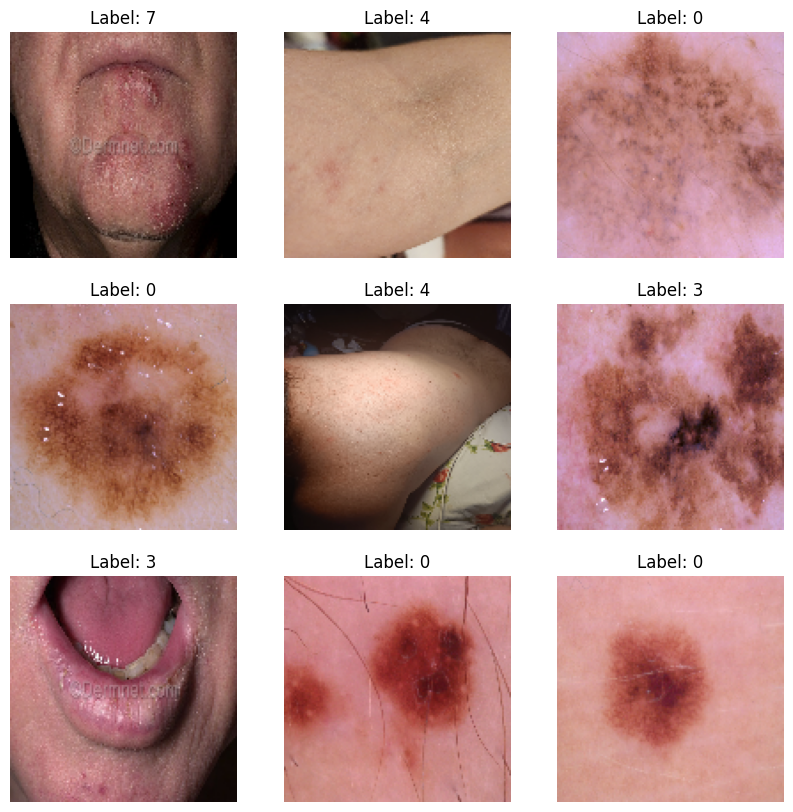

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataset))

# Convert tensor to NumPy array for visualization
image_batch = image_batch.numpy().astype("uint8")  # Ensure values are in 0-255 range

# Define number of images to visualize
num_images = 9

# Plot images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])  # Ensure correct format
    plt.title(f"Label: {label_batch[i].numpy()}")  # Convert label tensor to integer
    plt.axis("off")

plt.show()

### Apply data augmentation and normalization for these images

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define Data Augmentation
data_augmentation = tf.keras.Sequential([
    #layers.RandomFlip("horizontal"),
    #layers.RandomRotation(0.2),
    #layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

# Define Normalization Layer
normalization_layer = Rescaling(1./255)

# Function to Apply Augmentation + Normalization
def preprocess_train(image, label):
    image = data_augmentation(image, training=True)  # Apply Augmentation
    image = normalization_layer(image)  # Normalize
    return image, label

def preprocess_val_test(image, label):
    image = normalization_layer(image)  # Only Normalize
    return image, label

# Apply Transformations Efficiently
train_dataset = train_dataset.map(preprocess_train).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_val_test).cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_val_test).cache().prefetch(tf.data.AUTOTUNE)

print(f"Train batches: {len(train_dataset)}, Test batches:  {len(test_dataset)}, Validation batches: {len(val_dataset)}")

Train batches: 849, Test batches:  107, Validation batches: 107


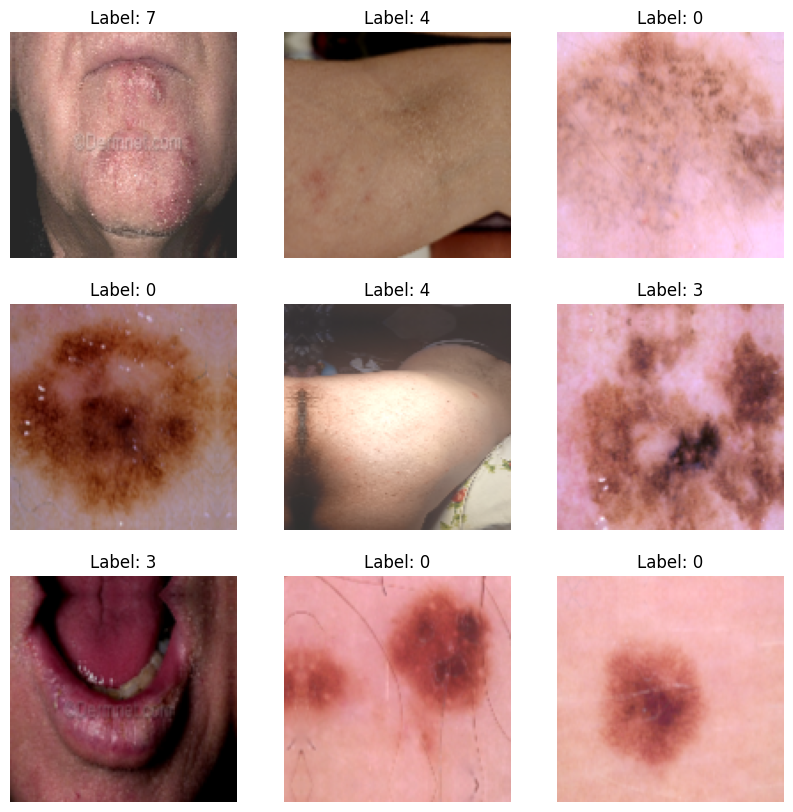

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataset))

# Convert images to NumPy arrays and ensure they are in the correct format
image_batch = image_batch.numpy().astype("float32")  # Convert tensor to NumPy array (float32)

# Define number of images to visualize
num_images = min(9, image_batch.shape[0])  # Ensure we don’t exceed the batch size

# Plot images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])  # Display image
    plt.title(f"Label: {label_batch[i].numpy()}")  # Convert label tensor to NumPy
    plt.axis("off")

plt.show()


# Models

### Using MobileNet2 model to predict skin conditions

In [ ]:
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.activations import swish, relu

# Load Pre-trained Model (MobileNetV2)
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation=relu),
    layers.BatchNormalization(),
    layers.Dense(256, activation=relu),
    layers.Dropout(0.2),
    layers.Dense(8, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
# Define the optimizer with a fixed learning rate
optimizer = Adam(learning_rate=1e-4)  # Use a fixed learning rate

# Compile the model again
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Display Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,049,288 (11.63 MB)

 Trainable params: 790,280 (3.01 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 935ms/step - accuracy: 0.2674 - loss: 2.1950 - val_accuracy: 0.4000 - val_loss: 1.6125 - learning_rate: 1.0000e-04
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 608ms/step - accuracy: 0.4167 - loss: 1.6044 - val_accuracy: 0.4080 - val_loss: 1.5468 - learning_rate: 1.0000e-04
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 537ms/step - accuracy: 0.4732 - loss: 1.4523 - val_accuracy: 0.4080 - val_loss: 1.5527 - learning_rate: 1.0000e-04
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 499ms/step - accuracy: 0.4886 - loss: 1.3854 - val_accuracy: 0.4160 - val_loss: 1.5215 - learning_rate: 1.0000e-04
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - accuracy: 0.5421 - loss: 1.2929 - val_accuracy: 0.4380 - val_loss: 1.4989 - learning_rate: 1.0000e-04
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.5466 - loss: 1.2515 - val_accuracy: 0.4640 - val_loss: 1.5125 - learning_rate: 1.0000e-04
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 662ms/step - accuracy: 0.4742 - loss: 1.4527
Test Accuracy: 46.60%


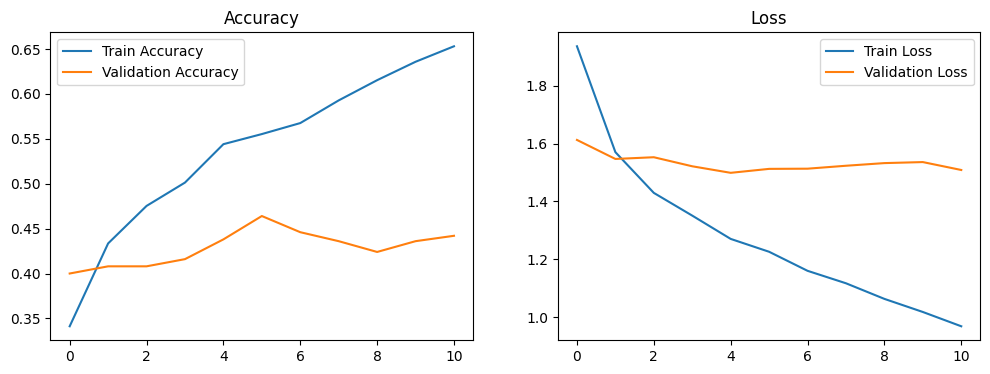

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Keep earlier layers frozen

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1203 - loss: 2.6870 - val_accuracy: 0.2800 - val_loss: 2.0649 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2719 - loss: 2.0666 - val_accuracy: 0.3000 - val_loss: 1.8886 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4430 - loss: 1.6889 - val_accuracy: 0.3200 - val_loss: 1.7846 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4654 - loss: 1.5052 - val_accuracy: 0.3800 - val_loss: 1.7298 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5395 - loss: 1.3318 - val_accuracy: 0.3800 - val_loss: 1.7025 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5738 - loss: 1.2634 - val_accuracy: 0.4000 - val_loss: 1.6786 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6223 - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3650 - loss: 1.8054    
Test Accuracy: 36.00%


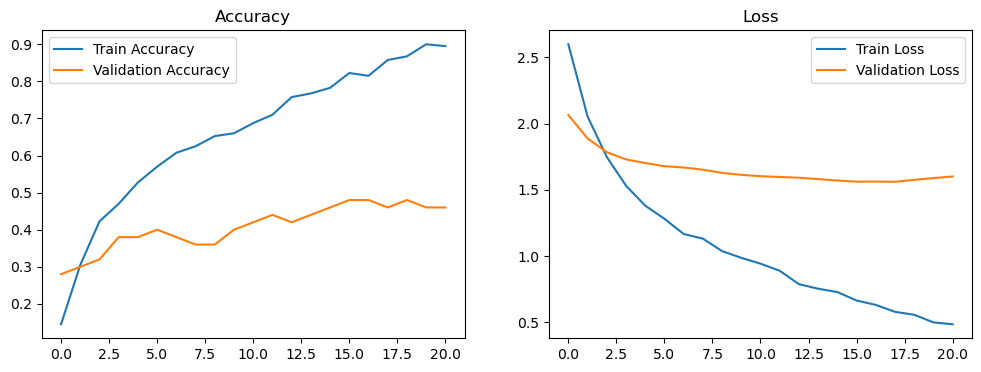

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

### Using EfficientNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
num_classes=8
# Load Pretrained Model without the top (fully connected layers)
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the convolutional base

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="swish")(x)
x = BatchNormalization()(x)  # Prevent overfitting
x = Dense(256, activation="swish")(x)  # Swish activation
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)  # Change for binary/multi-class

# Build Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model.summary()


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_1 (Cast)                 │ (None, 128, 128, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ cast_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               7 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 129, 129, 3)       │               0 │ rescaling_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 48)        │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 48)        │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 48)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 64, 64, 48)        │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 64, 64, 48)        │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 64, 64, 48)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 18,727,271 (71.44 MB)

 Trainable params: 1,052,424 (4.01 MB)

 Non-trainable params: 17,674,847 (67.42 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.1513 - loss: 3.2508 - val_accuracy: 0.1600 - val_loss: 2.0779
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.1614 - loss: 3.1033 - val_accuracy: 0.1200 - val_loss: 2.0938
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.2113 - loss: 2.4447 - val_accuracy: 0.0600 - val_loss: 2.0436
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.2217 - loss: 2.3225 - val_accuracy: 0.2800 - val_loss: 2.0292
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.2195 - loss: 2.2579 - val_accuracy: 0.2800 - val_loss: 1.9946
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.2674 - loss: 2.1391 - val_accuracy: 0.2800 - val_loss: 2.0009
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.2564 - loss: 2.0460 - val_accuracy: 0.3400 - val_loss: 1.9948
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.2668 - loss: 2.1034 - val_accuracy: 0.2800 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.3279 - loss: 1.9872
Test Accuracy: 32.00%


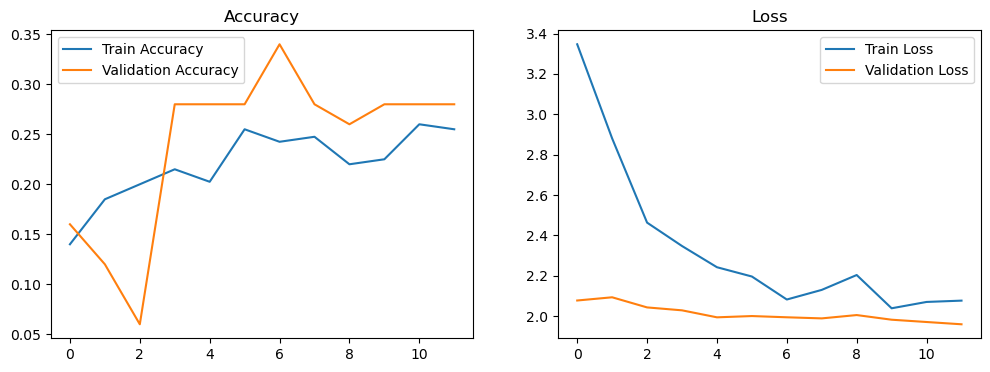

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Unfreeze last layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ cast_1 (Cast)                 │ (None, 128, 128, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ cast_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               7 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 129, 129, 3)       │               0 │ rescaling_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 48)        │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 48)        │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 48)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 64, 64, 48)        │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 64, 64, 48)        │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 64, 64, 48)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 18,727,271 (71.44 MB)

 Trainable params: 5,640,056 (21.52 MB)

 Non-trainable params: 13,087,215 (49.92 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 357s 21s/step - accuracy: 0.1935 - loss: 2.2634 - val_accuracy: 0.3000 - val_loss: 1.9915
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 259s 20s/step - accuracy: 0.1987 - loss: 2.1873 - val_accuracy: 0.2800 - val_loss: 1.9879
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 260s 19s/step - accuracy: 0.2232 - loss: 2.1994 - val_accuracy: 0.2800 - val_loss: 1.9904
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 251s 19s/step - accuracy: 0.2325 - loss: 2.1695 - val_accuracy: 0.2800 - val_loss: 1.9992
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 262s 20s/step - accuracy: 0.2355 - loss: 2.1793 - val_accuracy: 0.2800 - val_loss: 2.0105
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 256s 19s/step - accuracy: 0.2213 - loss: 2.0930 - val_accuracy: 0.2800 - val_loss: 2.0209


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3279 - loss: 1.9797
Test Accuracy: 32.00%


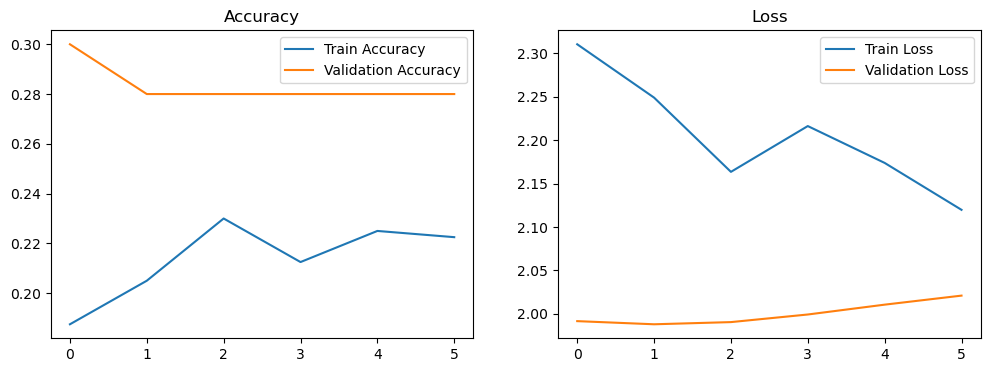

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

Mobile is consistently performing better. Let's try  optimizing it using hyperparamter tuning
### Hyperparameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
import keras_tuner as kt

# Define number of classes (update with your actual number)
num_classes = 8

def build_model(hp):
    # Use ResNet50 as the convolutional base
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze the base model initially

    # Build the model
    inputs = Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    # Tune number of dense units: try values between 64 and 512 (default 256)
    dense_units = hp.Int("dense_units", min_value=256, max_value=512, step=64, default=256)
    x = Dense(dense_units, activation='relu')(x)
    # Tune dropout rate: try values between 0.2 and 0.4 (default 0.2)
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step=0.1, default=0.2)
    x = Dropout(dropout_rate)(x)

    # Tune number of dense units: try values between 64 and 512 (default 256)
    dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=64, default=64)
    x = Dense(dense_units, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Tune the learning rate: sampling logarithmically between 1e-5 and 1e-3 (default 1e-4)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="LOG", default=1e-4)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create a Keras Tuner search object using RandomSearch (you can also try Hyperband)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,          # Number of models to try
    executions_per_trial=2, # Train each model twice for robustness
    directory='model_tuning',
    project_name='SDD_hp_tuning'
)

# Optionally, show a summary of the search space
tuner.search_space_summary()

# Start hyperparameter search
tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10,  # You might want to start with a low number of epochs
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Display a summary of the search results
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [01h 22m 48s]
val_accuracy: 0.48099999129772186

Best val_accuracy So Far: 0.4819999933242798
Total elapsed time: 06h 40m 11s
Results summary
Results in model_tuning\SDD_hp_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
dense_units: 256
dropout_rate: 0.2
learning_rate: 0.0002511502810092802
Score: 0.4819999933242798

Trial 4 summary
Hyperparameters:
dense_units: 512
dropout_rate: 0.4
learning_rate: 0.00033250455302692754
Score: 0.48099999129772186

Trial 1 summary
Hyperparameters:
dense_units: 448
dropout_rate: 0.30000000000000004
learning_rate: 0.0001489726519290489
Score: 0.47300000488758087

Trial 3 summary
Hyperparameters:
dense_units: 320
dropout_rate: 0.2
learning_rate: 1.545610507300449e-05
Score: 0.4270000010728836

Trial 0 summary
Hyperparameters:
dense_units: 320
dropout_rate: 0.30000000000000004
learning_rate: 1.4166056989575419e-05
Score: 0.4189999997615814


C:\Users\abhig\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Optionally, you can unfreeze some layers in the base model for fine-tuning
best_model.layers[1].trainable = True

# Recompile with a lower learning rate for fine-tuning
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the best model further if needed
history = best_model.fit(train_dataset,
                         validation_data=val_dataset,
                         epochs=100,
                         callbacks=[
                             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
                         ])

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.3084 - loss: 1.9588 - val_accuracy: 0.4460 - val_loss: 1.5820
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.3651 - loss: 1.7530 - val_accuracy: 0.4480 - val_loss: 1.6936
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.4116 - loss: 1.6536 - val_accuracy: 0.4540 - val_loss: 1.7181
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.4121 - loss: 1.6151 - val_accuracy: 0.4380 - val_loss: 1.7266


In [ ]:
best_model.save("best_fine_tuned_model.h5")

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("best_fine_tuned_model.h5")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Optimize for size and speed
tflite_model = converter.convert()

# Save the converted model
with open("best_fine_tuned_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite format!")

INFO:tensorflow:Assets written to: C:\Users\abhig\AppData\Local\Temp\tmpn2g1c5xm\assets


INFO:tensorflow:Assets written to: C:\Users\abhig\AppData\Local\Temp\tmpn2g1c5xm\assets


Saved artifact at 'C:\Users\abhig\AppData\Local\Temp\tmpn2g1c5xm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  3158380222928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380216400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380224080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380223888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380223312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380225424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380225808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380226192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380226000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158380222352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3158

#### Using Vision Transformers

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Define the Patches layer ---
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # Extract patches using tf.image.extract_patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Reshape patches to (batch_size, num_patches, patch_dim)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# --- Define the Patch Encoder layer ---
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # Linear projection of flattened patches.
        self.projection = layers.Dense(units=projection_dim)
        # Learnable position embeddings.
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# --- Build the Vision Transformer model ---
def create_vit_classifier(
    input_shape=(128, 128, 3),
    patch_size=16,
    num_layers=8,
    num_heads=4,
    embed_dim=64,
    mlp_dim=128,
    num_classes=2,
    dropout=0.1
):
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Calculate number of patches.
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    # Encode patches with linear projection and positional embedding.
    encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)

    # Create multiple layers of Transformer encoder blocks.
    for _ in range(num_layers):
        # Layer normalization.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head self-attention.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout
        )(x1, x1)
        # Skip connection.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Second normalization.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP block.
        mlp_output = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x3)
        mlp_output = layers.Dense(embed_dim)(mlp_output)
        # Skip connection.
        encoded_patches = layers.Add()([mlp_output, x2])

    # Create a representation by normalizing and flattening.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout)(representation)
    # Final classification head.
    outputs = layers.Dense(num_classes, activation="softmax")(representation)
    # Build the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Create the model ---
vit_classifier = create_vit_classifier(
    input_shape=(128, 128, 3),
    patch_size=16,      # 128/16 = 8 patches per side -> 64 patches total
    num_layers=8,       # Number of transformer blocks (adjust as needed)
    num_heads=4,        # Number of attention heads
    embed_dim=64,       # Embedding/Projection dimension
    mlp_dim=128,        # MLP hidden layer size in the transformer block
    num_classes=8,      # Change if you have more classes
    dropout=0.1
)

# so we use sparse categorical crossentropy.
vit_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Train the model ---
history = vit_classifier.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)

# --- Evaluate the model ---
test_loss, test_acc = vit_classifier.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# --- Predict on new images ---
# For example, to predict on the first batch of the test dataset:
for images, labels in test_dataset.take(1):
    predictions = vit_classifier.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    print("Predicted classes:", predicted_classes.numpy())
    print("True labels:", labels.numpy())


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.2827 - loss: 2.0516 - val_accuracy: 0.3560 - val_loss: 1.7262
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.3494 - loss: 1.8265 - val_accuracy: 0.3460 - val_loss: 1.6999
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.3550 - loss: 1.7542 - val_accuracy: 0.3660 - val_loss: 1.6720
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1726s 14s/step - accuracy: 0.3560 - loss: 1.7263 - val_accuracy: 0.3600 - val_loss: 1.6838
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3105s 2s/step - accuracy: 0.3654 - loss: 1.7233 - val_accuracy: 0.3700 - val_loss: 1.6768
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.3845 - loss: 1.6820 - val_accuracy: 0.3480 - val_loss: 1.6785
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.3782 - loss: 1.6815 - val_accuracy: 0.3800 - val_loss: 1.6225
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.3642 - loss: 1.6590 - val_a